## Info

I saw some individuals use a sequential format for their medium articles and I decided to post some of my own as well as a personal skill expanding exercise. The original data I found was from https://www.kaggle.com/datasets/wordsforthewise/lending-club but unfortunately there are no longer any useful data dictionaries to find which causes some issues in understanding of the data.

For the article:
- https://medium.com/pythoneers/9-different-ways-to-embedded-code-in-medium-9213cb4c0a2e

**In this notebook we examine the data some, clean it up to a certain point, and then save it down for use in later notebooks.**


<a id="toc"></a>
### Contents

[Accepted Loans](#aloans)

[Null Exploration](#nullex)

[Accepted Loans - Object Cols](#aloans_obj)

[Accepted Loans - Correlations](#aloans_corr)

[More Null Fills](#morenf)

[Rejected Loans](#rloans)    

In [2]:
import pandas as pd
import sidetable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import gc

pd.set_option('max_columns',150)
pd.set_option('max_rows',150)

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
def reduce_mem_usage(df, verbose=True):
    '''Reduces memory usage for large data sets with devices with low memory.'''
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
# headers = pd.read_csv('data/CAS Header File.csv').columns.tolist()
# print(headers)
# chk = reduce_mem_usage(pd.read_csv('data/2017Q1.csv', delimiter='|', names=headers))
# print(chk.shape)
# chk.head()

# ## number of months delinquent
# chk['Current Loan Delinquency Status'].value_counts(dropna=False)
# chk['Remaining Months To Maturity'].value_counts(dropna=False)

## Exploration

<a id="aloans"></a>
### Accepted Loans
[Table of Contents](toc)

In [5]:
## accepted loan data
adata = reduce_mem_usage(pd.read_csv('data/accepted_2007_to_2018q4.csv'))
print(adata.shape)
adata.head()

C:\Users\schillw\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3134: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Mem. usage decreased to 1224.59 Mb (53.0% reduction)
(2260701, 151)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,...,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.992188,123.00,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.910156,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.703125,13.0,w,0.0,0.0,4420.0,4420.0,3600.0,821.5,0.0,0.0,0.0,Jan-2019,122.6875,NaN,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,NaN,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,...,1.0,4.0,4.0,20701.0,1506.0,37.187500,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.875,0.000000,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24704.0,24704.0,24704.0,36 months,11.992188,820.50,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.062500,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.203125,38.0,w,0.0,0.0,25680.0,25680.0,24704.0,979.5,0.0,0.0,0.0,Jun-2016,926.5000,NaN,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,...,0.0,6.0,4.0,9733.0,57830.0,27.093750,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.375,7.699219,0.0,0.0,314017.0,39475.0,79300.

In [6]:
adata.tail()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,...,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
2260696,88985880,NaN,40000.0,40000.0,40000.0,60 months,10.492188,859.50,B,B3,Vice President,9 years,MORTGAGE,227000.0,Verified,Oct-2016,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,NaN,907xx,CA,12.750000,7.0,Feb-1995,705.0,709.0,1.0,9.0,NaN,5.0,0.0,8633.0,64.875,37.0,f,23248.0,23248.0,24896.0,24896.0,16752.0,8156.0,0.00000,0.0,0.0,Mar-2019,859.50,Apr-2019,Mar-2019,724.0,720.0,0.0,10.0,1.0,Individual,NaN,NaN,NaN,0.0,0.0,28398.0,0.0,2.0,0.0,1.0,15.0,19765.0,46.0,0.0,0.0,5141.0,51.0,13300.0,...,0.0,2.0,2.0,5680.0,4070.0,66.8750,0.0,0.0,154.0,258.0,33.0,15.0,3.0,41.0,9.0,1.0,9.0,6.0,2.0,3.0,2.0,15.0,9.0,3.0,23.0,3.0,5.0,0.0,0.0,7.0,0.0,75.6875,50.0,0.0,0.0,55970.0,28398.0,12300.0,42670.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2260697,88224441,NaN,24000.0,24000.0,24000.0,60 months,14.492188,564.50,C,C4,Program Manager,6 years,RENT,110000.0,Not Verified,Oct-2016,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,334xx,FL,18.296875,0.0,Jul-1999,660.0,664.0,0.0,67.0,72.0,10.0,1.0,17641.0,68.125,31.0,f,0.0,0.0,6756.0,6756.0,3522.0,3234.0,0.00000,0.0,0.0,Oct-2017,564.50,NaN,Mar-2019,594.0,590.0,0.0,67.0,1.0,Individual,NaN,NaN,NaN,0.0,0.0,62426.0,0.0,2.0,0.0,2.0,20.0,44785.0,78.0,1.0,5.0,6172.0,73.0,25900.0,...,0.0,1.0,7.0,6243.0,4660.0,77.5000,0.0,0.0,132.0,206.0,9.0,9.0,2.0,9.0,NaN,9.0,NaN,1.0,5.0,7.0,5.0,15.0,4.0,8.0,24.0,7.0,10.0,0.0,0.0,0.0,1.0,96.1875,40.0,1.0,0.0,846

In [7]:
## drop the last two
print(adata.shape)
adata = adata[~adata.loan_amnt.isnull()]
print(adata.shape)

(2260701, 151)
(2260668, 151)


In [8]:
gc.collect()

50

- **go by issue date to filter down**
- **many more features than rejected data**

In [9]:
adata['issue_d'] = pd.to_datetime(adata.issue_d)

for item in [2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018]:
    tmp = adata[adata.issue_d.dt.year==item]
    print(f"Year = {item},  number of records = {len(tmp) :,.0f}")
    print(tmp.issue_d.dt.month.unique())

Year = 2007,  number of records = 603
[12 11 10  9  8  7  6]
Year = 2008,  number of records = 2,393
[12 11 10  9  8  7  6  5  4  3  2  1]
Year = 2009,  number of records = 5,281
[12 11 10  9  8  7  6  5  4  3  2  1]
Year = 2010,  number of records = 12,537
[12 11 10  9  8  7  6  5  4  3  2  1]
Year = 2011,  number of records = 21,721
[12 11 10  9  8  7  6  5  4  3  2  1]
Year = 2012,  number of records = 53,367
[12 11 10  9  8  7  6  5  4  3  2  1]
Year = 2013,  number of records = 134,814
[12 11 10  9  8  7  6  5  4  3  2  1]
Year = 2014,  number of records = 235,629
[12 11 10  9  8  7  6  5  4  3  2  1]
Year = 2015,  number of records = 421,095
[12 11 10  9  8  7  6  5  4  3  2  1]
Year = 2016,  number of records = 434,407
[ 6  5  4  3  2  1  9  8  7 12 11 10]
Year = 2017,  number of records = 443,579
[ 9  8  7  6  5  4  3  2  1 12 11 10]
Year = 2018,  number of records = 495,242
[ 3  2  1  9  8  7 12 11 10  6  5  4]


- **based on the data, lets arbitrarily use 2015 and then we can potentially do a forward or backtest model down the road**

In [10]:
arbitrary_year = 2015
df = adata[adata.issue_d.dt.year == arbitrary_year]
print(df.shape)
gc.collect()

(421095, 151)


107

**Thats significantly more manageable**

<a id="nullex"></a>
### Null Exploration
[Table of Contents](toc)

In [11]:
nulls = df.isnull().sum()/len(df) * 100
nulls_gt10 = nulls[nulls > 10] ## greater than 10% null
nulls_gt50 = nulls[nulls > 50] ## greater than 10% null

In [12]:
## we can deal with ones under 50
# nulls_gt10
nulls_gt50

member_id                                     100.000000
desc                                           99.989314
mths_since_last_record                         82.328216
next_pymnt_d                                   89.182963
mths_since_last_major_derog                    70.854795
annual_inc_joint                               99.878650
dti_joint                                      99.879125
verification_status_joint                      99.878650
open_acc_6m                                    94.924661
open_act_il                                    94.924661
open_il_12m                                    94.924661
open_il_24m                                    94.924661
mths_since_rcnt_il                             95.058122
total_bal_il                                   94.924661
il_util                                        95.578907
open_rv_12m                                    94.924661
open_rv_24m                                    94.924661
max_bal_bc                     

- **we will drop nulls past 50% and do what we can for the rest**

In [13]:
df = df.drop(nulls_gt50.index, axis=1)
df.shape

(421095, 94)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421095 entries, 0 to 421094
Data columns (total 94 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   id                          421095 non-null  object        
 1   loan_amnt                   421095 non-null  float16       
 2   funded_amnt                 421095 non-null  float16       
 3   funded_amnt_inv             421095 non-null  float16       
 4   term                        421095 non-null  object        
 5   int_rate                    421095 non-null  float16       
 6   installment                 421095 non-null  float16       
 7   grade                       421095 non-null  object        
 8   sub_grade                   421095 non-null  object        
 9   emp_title                   397221 non-null  object        
 10  emp_length                  397278 non-null  object        
 11  home_ownership              421095 non-

In [16]:
nulls = df.isnull().sum()/len(df) * 100
nulls[nulls > 0]

emp_title                  5.669505
emp_length                 5.655968
title                      0.031347
dti                        0.000475
mths_since_last_delinq    48.436101
revol_util                 0.038471
last_pymnt_d               0.069818
last_credit_pull_d         0.001662
bc_open_to_buy             0.941118
bc_util                    1.003811
mo_sin_old_il_acct         2.910032
mths_since_recent_bc       0.901934
mths_since_recent_inq     10.591197
num_rev_accts              0.000237
num_tl_120dpd_2m           4.566665
percent_bc_gt_75           1.006661
dtype: float64

- emp_title will get narrowed down so the nulls can fall into missing or other
- emp_length will be changed to an int and then the mean or median will be used
- title (of the loan) can be missing
- dti can be 0 since there are so few
- revolving utilization can be defined as 0
- months since last delinq can be 0 as we can assume that since they are in the accepted data, they have a low delinquency
    - same for months since recent inqury
- this hasnt been brought up yet but the "bc" cols will be dropped since we arent exactly sure what "bc" refers to
- the last pymnt d(date) fields will be re organized to reflect parts of the date (month, year, etc)
    - or they may be dropped all together if there are "days since" last payment for example
- number of termloans (tl) 120 days past due, not sure what the 2m stands for but this could also be 0
    - this one could be more complicated and we can base it off of whether or not they even have any term loans
    - 0 is simpler

In [20]:
df['emp_title'] = df['emp_title'].fillna('missing')

<a id="aloans_obj"></a>
### Accepted Loans - Object Cols
[Table of Contents](toc)

In [21]:
df.select_dtypes(include='object').head()

,id,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,last_credit_pull_d,application_type,hardship_flag,disbursement_method,debt_settlement_flag
0,68407277,36 months,C,C4,leadman,10+ years,MORTGAGE,Not Verified,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,190xx,PA,Aug-2003,w,Jan-2019,Mar-2019,Individual,N,Cash,N
1,68355089,36 months,C,C1,Engineer,10+ years,MORTGAGE,Not Verified,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,Business,577xx,SD,Dec-1999,w,Jun-2016,Mar-2019,Individual,N,Cash,N
2,68341763,60 months,B,B4,truck driver,10+ years,MORTGAGE,Not Verified,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,NaN,605xx,IL,Aug-2000,w,Jun-2017,Mar-2019,Joint App,N,Cash,N
3,66310712,60 months,C,C5,Information Systems Officer,10+ years,MORTGAGE,Source Verified,Current,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,076xx,NJ,Sep-2008,w,Feb-2019,Mar-2019,Individual,N,Cash,N
4,68476807,60 months,F,F1,Contract Specialist,3 years,MORTGAGE,Source Verified,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,major_purchase,Major purchase,174xx,PA,Jun-1998,w,Jul-2016,Mar-2018,Individual,N,Cash,N


- **there is a lot of information here**
- we will keep id
- we can change the rest of the object cols to suit our needs
- rename columns for easier understanding
- assuming the tl = termloan and il = installment loan
- not cure what "bc" accounts for so we will not use the features with bc in them
    - this is for simplicity and brevity
- ...

In [22]:
new_cols = [c.replace('_tl','_termloan').replace('_il','_instalmloan') for c in df.columns]
new_cols

['id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'last_credit_pull_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'policy_code',
 'application_type',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'total_rev_hi_lim',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_ope

In [23]:
df.columns = new_cols

In [24]:
bc_cols = [c for c in df.columns if '_bc' in c or 'bc_' in c]
print(bc_cols, end=', ')

['bc_open_to_buy', 'bc_util', 'mths_since_recent_bc', 'num_actv_bc_termloan', 'num_bc_sats', 'num_bc_termloan', 'percent_bc_gt_75', 'total_bc_limit'], 

In [25]:
df = df.drop(bc_cols, axis=1)

**I like to check out object cols this way**

In [26]:
for item in df.select_dtypes(include='object').columns:
    vc = df[item].value_counts(dropna=False)
    if len(vc) <= 15:
        print(vc)
        print(" ="*20)
    else:
        print(item, " - more than 15 unique values.")
        print(" ="*20)

id  - more than 15 unique values.
 = = = = = = = = = = = = = = = = = = = =
 36 months    283173
 60 months    137922
Name: term, dtype: int64
 = = = = = = = = = = = = = = = = = = = =
C    120567
B    117606
A     73336
D     62654
E     34948
F      9817
G      2167
Name: grade, dtype: int64
 = = = = = = = = = = = = = = = = = = = =
sub_grade  - more than 15 unique values.
 = = = = = = = = = = = = = = = = = = = =
emp_title  - more than 15 unique values.
 = = = = = = = = = = = = = = = = = = = =
10+ years    141521
2 years       37497
< 1 year      34340
3 years       33430
1 year        27473
5 years       24930
4 years       24506
NaN           23817
8 years       21560
7 years       18414
6 years       16838
9 years       16769
Name: emp_length, dtype: int64
 = = = = = = = = = = = = = = = = = = = =
MORTGAGE    207683
RENT        167644
OWN          45766
ANY              2
Name: home_ownership, dtype: int64
 = = = = = = = = = = = = = = = = = = = =
Source Verified    184768
Verified    

**Lets do some conversion to numerical...**

In [27]:
## 36 or 60
df['term_int'] = df['term'].apply(lambda x: str(x)[:3].replace(' ','').replace('<','0')).replace('na',np.nan).astype(int)
pd.concat([df.term.value_counts(dropna=False), df.term_int.value_counts(dropna=False)],axis=1)

,term,term_int
36 months,283173.0,NaN
60 months,137922.0,NaN
36,NaN,283173.0
60,NaN,137922.0


In [28]:
## assuming G is the bottom we will reverse order
grade_dict = {'G':0,'F':1,'E':2,'D':3,'C':4,'B':5,'A':6}
df['grade_val'] = df['grade'].map(grade_dict)

pd.concat([df.grade.value_counts(dropna=False), df.grade_val.value_counts(dropna=False)],axis=1)

,grade,grade_val
0,NaN,2167.0
1,NaN,9817.0
2,NaN,34948.0
3,NaN,62654.0
4,NaN,120567.0
5,NaN,117606.0
6,NaN,73336.0
A,73336.0,NaN
B,117606.0,NaN
C,120567.0,NaN


In [31]:
## we will fill with 0 for simplicity
df['emp_length_int'] = df['emp_length'].apply(lambda x: str(x)[:2].replace(' ','').replace('<','0')).replace('na',np.nan).astype(float) 

df['emp_length_int'] = df.emp_length_int.fillna(df.emp_length_int.median()).astype(int)

pd.concat([df.emp_length.value_counts(dropna=False), df.emp_length_int.value_counts(dropna=False)],axis=1)

,emp_length,emp_length_int
NaN,23817.0,NaN
0,NaN,34340.0
1,NaN,27473.0
2,NaN,37497.0
3,NaN,33430.0
4,NaN,24506.0
5,NaN,24930.0
6,NaN,40655.0
7,NaN,18414.0
8,NaN,21560.0


**The median fill ended up at 6 years**

In [32]:
## DATE RELATED FEATURES
df['earliest_crdt_line_year'] = pd.to_datetime(df.earliest_cr_line).dt.year
df['earliest_crdt_line_month'] = pd.to_datetime(df.earliest_cr_line).dt.month

df['issue_date_month'] = pd.to_datetime(df.issue_d).dt.month
df['issue_date_dow'] = pd.to_datetime(df.issue_d).dt.dayofweek

In [33]:
## OTHER BINARIES
df['verified'] = np.where(df.verification_status != 'Not Verified', 1, 0)
df['initial_list_status_w'] = np.where(df.initial_list_status == 'w', 1, 0)
df['application_type_individual'] = np.where(df.application_type == 'Individual', 1, 0)
df['debt_settlement_flag_int'] = np.where(df.debt_settlement_flag == 'Yes', 1, 0)

In [34]:
## PURPOSES
(df.purpose.value_counts(dropna=False, normalize=True) * 100).round(2)

debt_consolidation    59.37
credit_card           24.23
home_improvement       6.01
other                  4.56
major_purchase         1.77
medical                0.94
car                    0.82
small_business         0.80
moving                 0.57
vacation               0.53
house                  0.34
renewable_energy       0.05
wedding                0.00
educational            0.00
Name: purpose, dtype: float64

**There is a big drop off in purpose but I am curious about medical so we will leave that.**
- Im curious about medical from personal perspective.

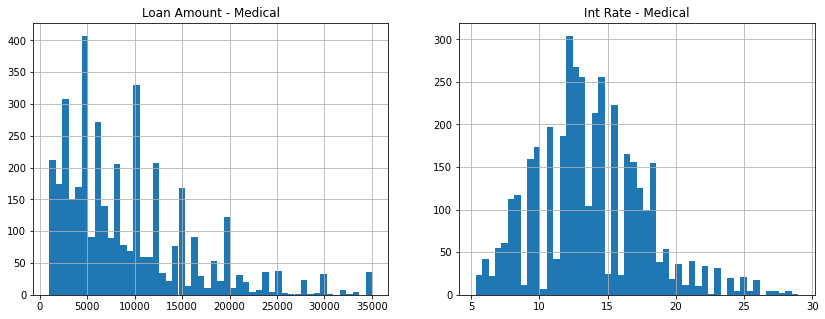

In [35]:
fig, ax=plt.subplots(1,2,figsize=(14,5))
df[df.purpose == 'medical']['loan_amnt'].hist(bins=50,ax=ax[0])
df[df.purpose == 'medical']['int_rate'].hist(bins=50,ax=ax[1])
ax[0].set_title("Loan Amount - Medical")
ax[1].set_title("Int Rate - Medical");

In [36]:
pd.concat([df[df.purpose == 'medical']['loan_amnt'].describe(),
           df[df.purpose == 'medical']['int_rate'].describe()], axis=1)

,loan_amnt,int_rate
count,3938.0,3938.000000
mean,inf,13.742188
std,inf,3.998047
min,1000.0,5.320312
25%,4200.0,11.218750
50%,7500.0,13.328125
75%,12000.0,16.546875
max,35008.0,28.984375


- Why are the mean and std "INF"?
- Thats a high average interest rate.

In [37]:
## CONSOLIDATE THESE
df['purpose_debt_consolidation'] = np.where(df.purpose == 'debt_consolidation', 1, 0)
df['purpose_credit_card'] = np.where(df.purpose == 'credit_card', 1, 0)
df['purpose_home_improvement'] = np.where(df.purpose == 'home_improvement', 1, 0)
df['purpose_major_purchase'] = np.where(df.purpose == 'major_purchase', 1, 0)
df['purpose_medical'] = np.where(df.purpose == 'medical', 1, 0) ## curious about this one
df['purpose_other'] = np.where((df.purpose != 'debt_consolidation')&(df.purpose != 'credit_card')&\
                               (df.purpose != 'home_improvement')&(df.purpose != 'major_purchase')&\
                               (df.purpose != 'medical'), 1, 0)

In [38]:
## EMP TITLE
df.emp_title.str.lower().value_counts(normalize=True, dropna=False) * 100

missing                               5.669505
teacher                               2.364312
manager                               2.127311
owner                                 1.448842
registered nurse                      1.055106
                                        ...   
due diligence coordinator             0.000237
fleet assistant                       0.000237
supervisir                            0.000237
vice president - commercial credit    0.000237
contracting and licensing             0.000237
Name: emp_title, Length: 102473, dtype: float64

- **There are a lot of different titles here, there might be some way to consolidate these but we might have to rely on NLP to assist.**
- I dont suppose this is going to do add a lot for us but its simple enough.
- It turns out that 'missing' is the most frequent title now since we filled it earlier.
    - It may seem counterintuitive, but knowing that it is missing is better than trying to impute what their title is.

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [43]:
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=10)
emp_title_tfidf = tfidf.fit_transform(df.emp_title.fillna('missing'))

In [44]:
et_tfidf = pd.DataFrame(emp_title_tfidf.todense(),
                        index=df.index,
                        columns=[f'tfidf_{i+1}' for i in range(tfidf.max_features)])

In [45]:
et_tfidf.head()

,tfidf_1,tfidf_2,tfidf_3,tfidf_4,tfidf_5,tfidf_6,tfidf_7,tfidf_8,tfidf_9,tfidf_10
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [46]:
chk = et_tfidf.merge(df.emp_title.fillna('missing'), left_index=True, right_index=True)
chk.head()

,tfidf_1,tfidf_2,tfidf_3,tfidf_4,tfidf_5,tfidf_6,tfidf_7,tfidf_8,tfidf_9,tfidf_10,emp_title
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,leadman
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Engineer
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,truck driver
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Information Systems Officer
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Contract Specialist


In [47]:
chk.groupby('emp_title').sum().sum(axis=1).sort_values(ascending=False).head(20)

emp_title
missing                     23874.000000
Teacher                      8070.000000
Manager                      6802.000000
Supervisor                   3016.000000
Sales                        2588.000000
Project Manager              2364.000000
Office Manager               2115.000000
Director                     1969.000000
General Manager              1915.000000
manager                      1826.000000
teacher                      1743.000000
Engineer                     1622.000000
Sales Manager                1587.885340
Operations Manager           1242.000000
Administrative Assistant     1179.000000
Account Manager              1055.000000
sales                        1015.000000
Analyst                       941.000000
Executive Assistant           941.000000
Assistant Manager             939.770333
dtype: float64

In [48]:
## merge them
df = df.merge(et_tfidf, left_index=True, right_index=True)
print(df.shape)

(421095, 113)


In [49]:
## home ownershu=ip
home_own = pd.get_dummies(df.home_ownership, prefix='ho')
home_own.columns = [c.lower() for c in home_own.columns]

## loan status
loan_status = pd.get_dummies(df.loan_status, prefix='ls')
## probably would be easier to REGEX these than have all these replace statements
loan_status.columns = [c.lower().replace(' ','_').replace('-','to').replace('(','').replace(')','') for c in loan_status.columns]

print(df.shape)
df = df.merge(home_own, left_index=True, right_index=True).merge(loan_status, left_index=True, right_index=True)
print(df.shape)

(421095, 113)
(421095, 124)


**Lets remove some of these now**

In [50]:
drops = ['term', ## changed to int
         'issue_d', ## dont really need issue date since we have subsetted the data and grabbed some date data
         'grade', ## ranked
         'sub_grade', ## probably too deep
         'emp_length', ## changed to int
         'emp_title', ## TFIDF
         'url','title','zip_code','addr_state', ## dropping
         'earliest_cr_line', ## grabbed some date data
         'last_pymnt_d','last_credit_pull_d', ## we have months since columns for these
         'disbursement_method', ## only says cash so may not always have other items
         'pymnt_plan','hardship_flag', ## very limited
         'debt_settlement_flag', 'application_type','initial_list_status','verification_status', ## binarized
         'purpose', ## consolidated
         'home_ownership','loan_status', ## dummied        
        ]

In [51]:
df = df.drop(drops, axis=1)
print(df.shape)

(421095, 101)


<a id="aloans_corr"></a>
### Accepted Loans - Correlations
[Table of Contents](toc)

**Lets take a look and see if there are any strong correlations.**

In [52]:
df_corr = df.corr()

In [53]:
for c in df_corr.columns:
    tmp = df_corr[c]
    hcorr = tmp[(np.abs(tmp)>0.95)&(np.abs(tmp)<1.0)]
    if len(hcorr) > 0:
        print(hcorr)
        print(" ="*20)

funded_amnt_inv    0.999994
Name: loan_amnt, dtype: float64
 = = = = = = = = = = = = = = = = = = = =
funded_amnt_inv    0.999994
Name: funded_amnt, dtype: float64
 = = = = = = = = = = = = = = = = = = = =
loan_amnt      0.999994
funded_amnt    0.999994
Name: funded_amnt_inv, dtype: float64
 = = = = = = = = = = = = = = = = = = = =
grade_val   -0.971883
Name: int_rate, dtype: float64
 = = = = = = = = = = = = = = = = = = = =
fico_range_high    1.0
Name: fico_range_low, dtype: float64
 = = = = = = = = = = = = = = = = = = = =
fico_range_low    1.0
Name: fico_range_high, dtype: float64
 = = = = = = = = = = = = = = = = = = = =
num_sats    0.998602
Name: open_acc, dtype: float64
 = = = = = = = = = = = = = = = = = = = =
out_prncp_inv    0.999998
Name: out_prncp, dtype: float64
 = = = = = = = = = = = = = = = = = = = =
out_prncp    0.999998
Name: out_prncp_inv, dtype: float64
 = = = = = = = = = = = = = = = = = = = =
total_pymnt_inv    0.999996
total_rec_prncp    0.955484
Name: total_pymnt, dtype: 

**Here we have some high correlations.**
- loan_amt and funded_amt and funded_amnt_inv look nearly 1:1 so we could probably drop 2 of them
- grade val and interest rate are strongly inversely correlated which may be something we should consider down the road ;)
- we could probably average out the fico upper and lowers
- I am not sure why "num_sats" is but it is strongly correlated with open accounts, so we will drop it
- we will keep one out_prncp
- we will keep one of total_pymnt, total_pymnt_inv

- **some previous runs highlighted that policy_code and debt_settlement_flag were very sparse so we are dropping them**

In [54]:
## more drops
drops2 = ['policy_code','debt_settlement_flag_int','funded_amnt_inv','funded_amnt','out_prncp_inv','total_pymnt_inv']
df2 = df.drop(drops2, axis=1)

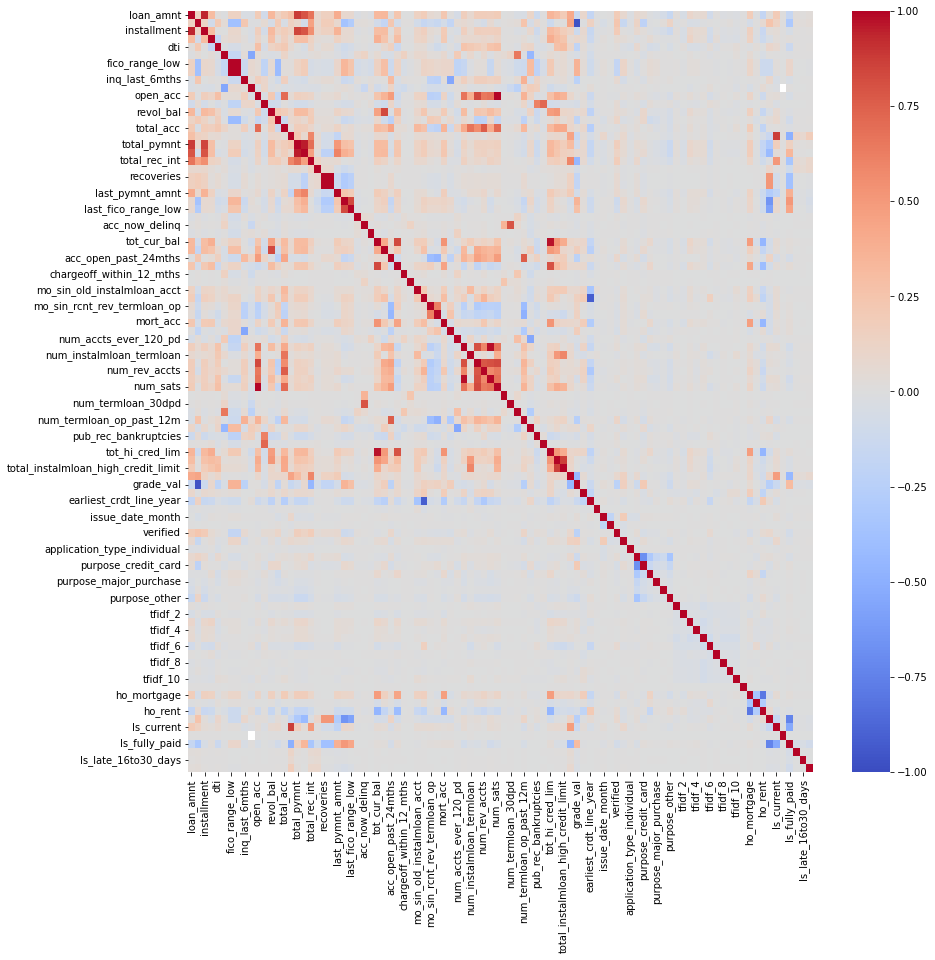

In [55]:
fig, ax=plt.subplots(1,1,figsize=(14,14))
sns.heatmap(df2.corr(), ax=ax, annot=False, vmin=-1, vmax=1, cmap='coolwarm');

- **still some large groupings of similar features**

In [56]:
df2.shape

(421095, 95)

- **This is too many features to try and histogram for everything**

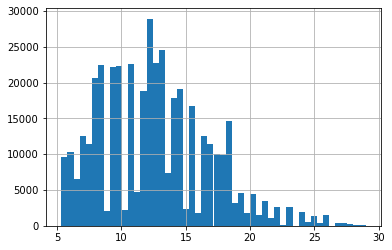

In [57]:
df2.int_rate.hist(bins=50);

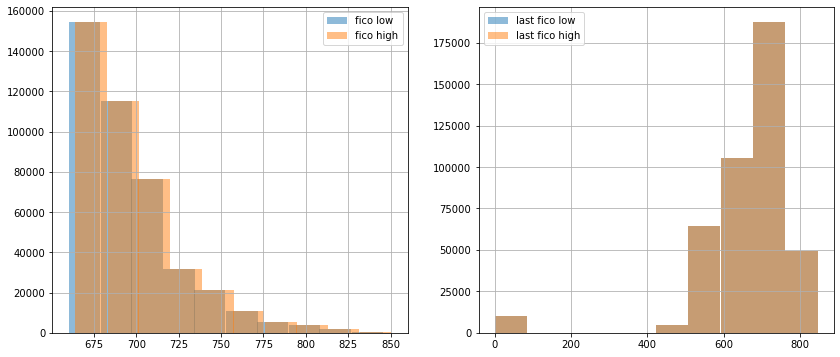

In [58]:
fig, ax=plt.subplots(1,2,figsize=(14,6))
df2.fico_range_low.hist(ax=ax[0], alpha=0.5)
df2.fico_range_high.hist(ax=ax[0], alpha=0.5)
ax[0].legend(['fico low','fico high'])
df2.last_fico_range_low.hist(ax=ax[1], alpha=0.5)
df2.last_fico_range_low.hist(ax=ax[1], alpha=0.5)
ax[1].legend(['last fico low','last fico high']);

- **Current FICO versus last vary wildly**
- **We can average the current and calculate differences for the others**

In [59]:
df2['current_fico_avg'] = (df2.fico_range_high+df.fico_range_low)/2.0

df2['fico_change_current_to_low'] = df2['current_fico_avg'] - df2['last_fico_range_low']
df2['fico_change_current_to_hi'] = df2['current_fico_avg'] - df2['last_fico_range_high']

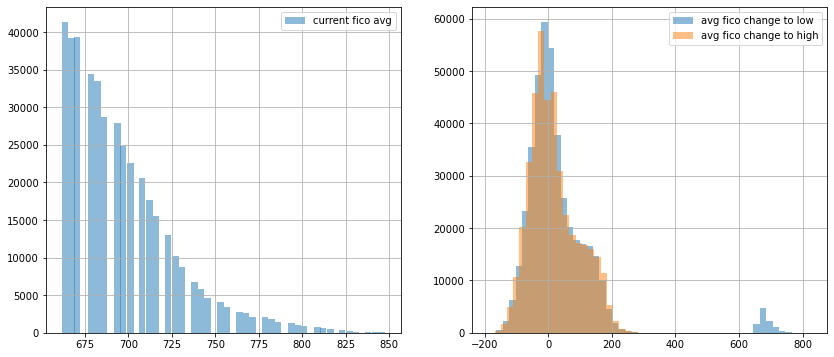

In [60]:
fig, ax=plt.subplots(1,2,figsize=(14,6))
df2.current_fico_avg.hist(ax=ax[0], alpha=0.5, bins=50)
ax[0].legend(['current fico avg'])
df2.fico_change_current_to_low.hist(ax=ax[1], alpha=0.5, bins=50)
df2.fico_change_current_to_hi.hist(ax=ax[1], alpha=0.5, bins=50)
ax[1].legend(['avg fico change to low','avg fico change to high']);

**There are some large swings in there**

### Variable Name Issues
- we dont have a data dictionary any more so some of these features are obvious by the name.

In [61]:
df2.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,total_pymnt,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_instalmloan_acct,mo_sin_old_rev_termloan_op,mo_sin_rcnt_rev_termloan_op,mo_sin_rcnt_termloan,mort_acc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_rev_termloan,num_instalmloan_termloan,num_op_rev_termloan,num_rev_accts,num_rev_termloan_bal_gt_0,num_sats,num_termloan_120dpd_2m,num_termloan_30dpd,num_termloan_90g_dpd_24m,num_termloan_op_past_12m,pct_termloan_nvr_dlq,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_instalmloan_high_credit_limit,term_int,grade_val,emp_length_int,earliest_crdt_line_year,earliest_crdt_line_month,issue_date_month,issue_date_dow,verified,initial_list_status_w,application_type_individual,purpose_debt_consolidation,purpose_credit_card,purpose_home_improvement,purpose_major_purchase,purpose_medical,purpose_other,tfidf_1,tfidf_2,tfidf_3,tfidf_4,tfidf_5,tfidf_6,tfidf_7,tfidf_8,tfidf_9,tfidf_10,ho_any,ho_mortgage,ho_own,ho_rent,ls_charged_off,ls_current,ls_default,ls_fully_paid,ls_in_grace_period,ls_late_16to30_days,ls_late_31to120_days,current_fico_avg,fico_change_current_to_low,fico_change_current_to_hi
count,421095.0,421095.000000,421095.000000,4.210950e+05,421093.00000,421095.0,421095.0,421095.0,421095.0,217133.0,421095.0,421095.0,4.210950e+05,420933.00000,421095.0,421095.0,421095.0,421095.0,421095.0,421095.0,421095.0,421095.0,421095.0,421095.0,421095.0,421095.000000,421095.000000,421095.000000,4.210950e+05,4.210950e+05,421095.0,421095.000000,421095.000000,421095.000000,408841.0,421095.0,421095.0,421095.0,421095.0,376496.0,421095.0,421095.0,421095.0,421095.0,421094.0,421095.0,421095.0,401865.000000,421095.000000,421095.00000,421095.0,421095.000,421095.000000,421095.000000,4.210950e+05,4.210950e+05,4.210950e+05,421095.000000,421095.000000,421095.000000,421095.000000,421095.000000,421095.000000,421095.000000,421095.000000,421095.000000,421095.000000,421095.000000,421095.000000,421095.000000,421095.000000,421095.000000,421095.000000,421095.000000,421095.000000,421095.000000,421095.000000,421095.000000,421095.000000,421095.000000,421095.000000,421095.000000,421095.000000,421095.000000,421095.000000,421095.000000,421095.000000,421095.000000,421095.000000,421095.000000,421095.000000,421095.000000,421095.000000,421095.000000,421095.0,421095.0,421095.0
mean,NaN,NaN,NaN,7.697237e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.768533e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.020264,0.006088,257.475586,1.400787e+05,3.365811e+04,NaN,13104.614258,0.010429,13.765183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000762,0.004044,0.09436,NaN,NaN,0.133301,0.064575,1.734060e+05,5.222139e+04,4.348090e+04,43.860763,4.222299,6.024460,1998.221997,6.749425,6.955383,3.121049,0.730913,0.634660,0.998786,0.593738,0.242285,0.060065,0.017690,0.009352,0.076871,0.027995,0.034030,0.040354,0.027673,0.147029,0.056696,0.034020,0.027703,0.028842,0.029043,0.000005,0.493197,0.108683,0.398114,0.180014,0.102825,0.000002,0.711816,0.001453,0.000663,0.003227,NaN,NaN,NaN
std,NaN,0.000000,NaN,7.392763e+04,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,2.419287e+04,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.157471,0.086487,2245.900879,1.552619e+05,3.766030e+04,0.0,15670.863281,0.117126,781.701355,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030167,0.068054,0.00000,0.0,0.000,0.386230,0.000000,1.756619e+05,4.907094e+04,4.392979e+04,11.263526,1.303615,3.603007,7.608292,3.366384,3.458167,1.936599,0.443486,0.481526,0.034814,0.491135,0.428466,0.237607,0.131821,0.096252,0.266387,0.164697,0.177592,0.194828,0.163430,0.3

In [62]:
## set index as id
df2['id'] = df2.id.astype(int)
df2.set_index('id', inplace=True)

In [63]:
## more drops
drops3 = ['fico_range_low','fico_range_high', ## the average will do fine for us
          'pub_rec', ## ??
          'out_prncp', ## some principal
          'last_fico_range_high','last_fico_range_low', ## going to use the difference from last fico avg
          'collections_12_mths_ex_med', ## collectiosn but to what
         ]

In [64]:
df2 = df2.drop(drops3, axis=1)

In [65]:
print(df2.shape)

(421095, 90)


<a id="morenf"></a>
### More Null Fills
[Table of Contents](toc)

In [69]:
df2_nulls = df2.isnull().sum()
df2_nulls[df2_nulls>0]/len(df2) * 100

dti                             0.000475
mths_since_last_delinq         48.436101
revol_util                      0.038471
mo_sin_old_instalmloan_acct     2.910032
mths_since_recent_inq          10.591197
num_rev_accts                   0.000237
num_termloan_120dpd_2m          4.566665
dtype: float64

- **dti = debt_to_income_ratio**
- **we can 0 fill months since last delinq as 0**
    - this assume they have had no delinquancies but this could also be tied to another feature
- **we can examine the rest but its probably the case they dont have things like:**
    - installments loans
    - high utilization
    - or "rev" accts
    - term loans

In [70]:
df2[df2_nulls[df2_nulls>0].index].describe()

,dti,mths_since_last_delinq,revol_util,mo_sin_old_instalmloan_acct,mths_since_recent_inq,num_rev_accts,num_termloan_120dpd_2m
count,421093.00000,217133.0,420933.00000,408841.0,376496.0,421094.0,401865.000000
mean,NaN,NaN,NaN,NaN,NaN,NaN,0.000762
std,NaN,0.0,0.00000,NaN,0.0,0.0,0.030167
min,0.00000,0.0,0.00000,0.0,0.0,2.0,0.000000
25%,12.59375,15.0,36.09375,101.0,2.0,9.0,0.000000
50%,18.59375,31.0,54.18750,130.0,5.0,13.0,0.000000
75%,25.34375,50.0,72.12500,153.0,10.0,19.0,0.000000
max,999.00000,176.0,193.00000,724.0,25.0,118.0,6.000000


In [71]:
## remaining null fills - keeping it simple
df2['dti'] = df2.dti.fillna(df2.dti.mean())

## there are much easier ways to do this through loops and pandas 
## but I wanted to be specific here incase we make changes later
df2['mths_since_last_delinq'] = df2.mths_since_last_delinq.fillna(0) 
df2['revol_util'] = df2.revol_util.fillna(0) 
df2['mo_sin_old_instalmloan_acct'] = df2.mo_sin_old_instalmloan_acct.fillna(0) 
df2['mths_since_recent_inq'] = df2.mths_since_recent_inq.fillna(0) 
df2['num_rev_accts'] = df2.num_rev_accts.fillna(0) 
df2['num_termloan_120dpd_2m'] = df2.num_termloan_120dpd_2m.fillna(0) 

**Lets save the cleaned accepted data down!**
- I ran into an error saving to parquet within data types so I opted for csv instead.

In [72]:
df2.to_csv('data/cleaned/accepted_2015.csv')

<a id="rloans"></a>
### Rejected Loans
[Table of Contents](toc)

In [73]:
rdata = reduce_mem_usage(pd.read_csv('data/rejected_2007_to_2018Q4.csv'))
rdata['Application Date'] = pd.to_datetime(rdata['Application Date'])
print(rdata.shape)
rdata.head()

Mem. usage decreased to 1476.60 Mb (22.2% reduction)
(27648741, 9)


,Amount Requested,Application Date,Loan Title,Risk_Score,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
0,1000.0,2007-05-26,Wedding Covered but No Honeymoon,693.0,10%,481xx,NM,4 years,0.0
1,1000.0,2007-05-26,Consolidating Debt,703.0,10%,010xx,MA,< 1 year,0.0
2,11000.0,2007-05-27,Want to consolidate my debt,715.0,10%,212xx,MD,1 year,0.0
3,6000.0,2007-05-27,waksman,698.0,38.64%,017xx,MA,< 1 year,0.0
4,1500.0,2007-05-27,mdrigo,509.0,9.43%,209xx,MD,< 1 year,0.0


**This data is signifcantly different but it makes sense.**
- From this standpoint, no one has done much to understand and record anything about these individuals.
- This is kind of like a prospect data set.

In [74]:
## just 2015
rdf = rdata[(rdata['Application Date'].dt.year==arbitrary_year)] 
rdf.shape

(2859379, 9)

In [75]:
rdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2859379 entries, 21719563 to 24578941
Data columns (total 9 columns):
 #   Column                Dtype         
---  ------                -----         
 0   Amount Requested      float32       
 1   Application Date      datetime64[ns]
 2   Loan Title            object        
 3   Risk_Score            float16       
 4   Debt-To-Income Ratio  object        
 5   Zip Code              object        
 6   State                 object        
 7   Employment Length     object        
 8   Policy Code           float16       
dtypes: datetime64[ns](1), float16(2), float32(1), object(5)
memory usage: 174.5+ MB


- **We have some similar columns though to the accepted data so we can make some assumptions and tie the two together.**
- Debt-to-Income Ratio = dti
- Amount Request = loan_amnt
- Risk_score = average fico score
- Loan Title = purpose
- employment length = employment length
- we can drop the rest

In [76]:
print(f"Total Record Ratio = {len(rdf)/len(df2) :.2f} times more rejected than accepted.")

Total Record Ratio = 6.79 times more rejected than accepted.


**Lets start by lining up some features**

C:\Users\schillw\AppData\Local\Temp\ipykernel_8284\3284512003.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdf['dti'] = rdf['Debt-To-Income Ratio'].apply(lambda x: float(x.replace('%','')))


Nulls = 0.000%


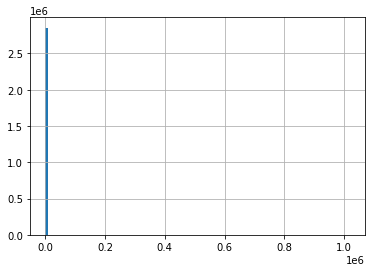

In [77]:
## drop the % but dont divide by 100 since the accepted is in the same type
rdf['dti'] = rdf['Debt-To-Income Ratio'].apply(lambda x: float(x.replace('%','')))

print(f"Nulls = {rdf.dti.isnull().sum()/len(rdf) * 100 :.3f}%")
rdf.dti.hist(bins=100);

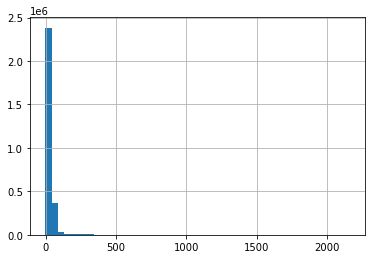

In [78]:
chk = rdf.dti
chk[chk < chk.std()].hist(bins=50);

**Less that 1 standard deviation is still significantly skewed.**

In [79]:
pd.concat([df2.dti.describe(), rdf.dti.describe()], axis=1).round(2)

,dti,dti
count,421093.00,2859379.00
mean,NaN,119.47
std,NaN,2165.67
min,0.00,-1.00
25%,12.59,6.24
50%,18.59,18.00
75%,25.34,34.25
max,999.00,1019525.00


**The median is close for accepted and rejected but everything else is much wider - assuming we dont have to divide by 100**

In [80]:
## grab first digits, replace some strings, fillna with 0 since there are few relative and change to int
## now its ranked
rdf['emp_length_int'] = rdf['Employment Length'].apply(lambda x: str(x)[:2].replace(' ','').replace('<','0')).replace('na',np.nan).fillna(0).astype(int)

C:\Users\schillw\AppData\Local\Temp\ipykernel_8284\2316569412.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdf['emp_length_int'] = rdf['Employment Length'].apply(lambda x: str(x)[:2].replace(' ','').replace('<','0')).replace('na',np.nan).fillna(0).astype(int)


In [81]:
## purposes
rdf['Loan Title'] = rdf['Loan Title'].replace('other','Other')
rdf['Loan Title'].value_counts(dropna=False)

C:\Users\schillw\AppData\Local\Temp\ipykernel_8284\3486698877.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdf['Loan Title'] = rdf['Loan Title'].replace('other','Other')


debt_consolidation                     1272917
Other                                   358088
credit_card                             304968
home_improvement                        148689
car                                     110387
Debt consolidation                       97090
moving                                   87441
Business Loan                            83657
medical                                  81523
major_purchase                           81145
small_business                           67451
Credit card refinancing                  40704
house                                    40076
vacation                                 35793
Home improvement                         14674
Business                                  8314
renewable_energy                          7072
Major purchase                            5394
Medical expenses                          3072
Car financing                             2858
Business Line Of Credit                   2536
Moving and re

- **We can do some cleaning here**

In [82]:
rdf['purpose'] = rdf['Loan Title'].apply(lambda x: x.lower().replace(' ','_'))
rdf['purpose'].value_counts(dropna=False)

C:\Users\schillw\AppData\Local\Temp\ipykernel_8284\511700546.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdf['purpose'] = rdf['Loan Title'].apply(lambda x: x.lower().replace(' ','_'))


debt_consolidation                     1370007
other                                   358088
credit_card                             304968
home_improvement                        163363
car                                     110387
moving                                   87441
major_purchase                           86539
business_loan                            83657
medical                                  81523
small_business                           67451
credit_card_refinancing                  40704
house                                    40076
vacation                                 37590
business                                  8314
renewable_energy                          7072
medical_expenses                          3072
car_financing                             2858
business_line_of_credit                   2536
moving_and_relocation                     2070
home_buying                               1333
green_loan                                 316
consolidation

In [83]:
## to match the accepted data
rdf['purpose_debt_consolidation'] = np.where((rdf.purpose == 'debt_consolidation')|(rdf.purpose == 'consolidate_debt')|\
                                              (rdf.purpose == 'consolidation_loan'), 1, 0)

rdf['purpose_credit_card'] = np.where((rdf.purpose == 'credit_card')|(rdf.purpose == 'credit_card_refinancing'), 1, 0)

rdf['purpose_home_improvement'] = np.where(rdf.purpose == 'home_improvement', 1, 0)

rdf['purpose_major_purchase'] = np.where((rdf.purpose == 'major_purchase')|(rdf.purpose == 'house')|(rdf.purpose == 'home_buying'), 1, 0)

rdf['purpose_medical'] = np.where((rdf.purpose == 'medical')|(rdf.purpose == 'medical_expenses'), 1, 0) ## curious about this one

rdf['purpose_other'] = np.where((rdf.purpose_debt_consolidation != 1)&(rdf.purpose_credit_card != 1)&\
                               (rdf.purpose_home_improvement != 1)&(rdf.purpose_major_purchase != 1)&\
                               (rdf.purpose_medical != 1), 1, 0)

C:\Users\schillw\AppData\Local\Temp\ipykernel_8284\3291702991.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdf['purpose_debt_consolidation'] = np.where((rdf.purpose == 'debt_consolidation')|(rdf.purpose == 'consolidate_debt')|\
C:\Users\schillw\AppData\Local\Temp\ipykernel_8284\3291702991.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdf['purpose_credit_card'] = np.where((rdf.purpose == 'credit_card')|(rdf.purpose == 'credit_card_refinancing'), 1, 0)
C:\Users\schillw\AppData\Local\Temp\ipykerne

**DROPS**

In [84]:
rdf.head()

,Amount Requested,Application Date,Loan Title,Risk_Score,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code,dti,emp_length_int,purpose,purpose_debt_consolidation,purpose_credit_card,purpose_home_improvement,purpose_major_purchase,purpose_medical,purpose_other
21719563,30000.0,2015-01-01,debt_consolidation,681.0,35.65%,958xx,CA,< 1 year,0.0,35.65,0,debt_consolidation,1,0,0,0,0,0
21719564,5000.0,2015-01-01,debt_consolidation,648.0,10.62%,945xx,CA,< 1 year,0.0,10.62,0,debt_consolidation,1,0,0,0,0,0
21719565,10000.0,2015-01-01,Debt consolidation,721.0,10.02%,750xx,TX,7 years,0.0,10.02,7,debt_consolidation,1,0,0,0,0,0
21719566,10000.0,2015-01-01,major_purchase,659.0,19.05%,853xx,AZ,< 1 year,0.0,19.05,0,major_purchase,0,0,0,1,0,0
21719567,5000.0,2015-01-01,debt_consolidation,501.0,10.73%,475xx,IN,< 1 year,0.0,10.73,0,debt_consolidation,1,0,0,0,0,0


In [85]:
r_drops = ['Loan Title','Zip Code','State','Employment Length','Policy Code','Debt-To-Income Ratio']
rdf = rdf.drop(r_drops, axis=1)

renames = {'Amount Requested':'loan_amnt','Application Date':'app_date','Risk_Score':'current_fico_avg'}
rdf = rdf.rename(columns=renames)

In [86]:
rdf.head()

,loan_amnt,app_date,current_fico_avg,dti,emp_length_int,purpose,purpose_debt_consolidation,purpose_credit_card,purpose_home_improvement,purpose_major_purchase,purpose_medical,purpose_other
21719563,30000.0,2015-01-01,681.0,35.65,0,debt_consolidation,1,0,0,0,0,0
21719564,5000.0,2015-01-01,648.0,10.62,0,debt_consolidation,1,0,0,0,0,0
21719565,10000.0,2015-01-01,721.0,10.02,7,debt_consolidation,1,0,0,0,0,0
21719566,10000.0,2015-01-01,659.0,19.05,0,major_purchase,0,0,0,1,0,0
21719567,5000.0,2015-01-01,501.0,10.73,0,debt_consolidation,1,0,0,0,0,0


In [87]:
rdf.isnull().sum()/len(rdf) * 100

loan_amnt                      0.000000
app_date                       0.000000
current_fico_avg              82.148187
dti                            0.000000
emp_length_int                 0.000000
purpose                        0.000000
purpose_debt_consolidation     0.000000
purpose_credit_card            0.000000
purpose_home_improvement       0.000000
purpose_major_purchase         0.000000
purpose_medical                0.000000
purpose_other                  0.000000
dtype: float64

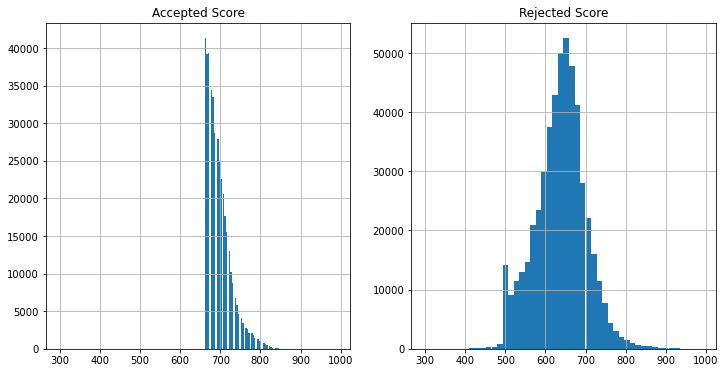

In [88]:
fig, ax=plt.subplots(1,2,figsize=(12,6), sharex=True)
df2.current_fico_avg.hist(bins = 50, ax=ax[0])
rdf.current_fico_avg.hist(bins = 50, ax=ax[1])
ax[0].set_title("Accepted Score")
ax[1].set_title("Rejected Score");

# fig, ax=plt.subplots(1,1,figsize=(12,6))
# sns.distplot(df2.current_fico_avg, ax=ax)
# sns.distplot(rdf.current_fico_avg, ax=ax)

In [89]:
pd.concat([df2.current_fico_avg.describe(), rdf.current_fico_avg.describe()],axis=1).round(2)

,current_fico_avg,current_fico_avg
count,421095.0,510451.0
mean,NaN,NaN
std,NaN,NaN
min,662.0,300.0
25%,672.0,599.0
50%,687.0,641.0
75%,712.0,677.0
max,847.5,990.0


In [90]:
print(f"Scores >= 662 from rejected = {len(rdf[rdf.current_fico_avg >= 662])/len(rdf) * 100 :.3f}%")

Scores >= 662 from rejected = 6.239%


In [91]:
len(rdf[rdf.current_fico_avg >= 662])/len(df2) * 100

42.36573694771963

**Unfortunately for us that risk score (current fico avg) is VERY sparse and there doesnt appear to be anything we can match back to on the accepted data - at the moment.**
- The distributions for both data sets are very different which highlights a potential issue for any modeling.
    - Since the accepted scores bottom out at 662 and the rejected at 300, we are going to either have to:
        - Cut the rejected scores at 662 and assume that is an established cut off point which may note be useful but would appear to balance out the data sets more.
        - Infer all the missing values together to potentially balance the score out.
        
- What if we combine these specific data sets and infer the missing values from there?
- The imputation of missing values is a tricky subject. If we were to impute the missing values on the rejected data set alone, we might not get something were satisfied with. But what if we combine some of the features from both accepted and rejected and impute from there?
- It would be better to do this after any kind of train / test splitting I think.

- **MORE TO COME!**

In [92]:
## save down 
rdf.to_csv('data/cleaned/rejected_2015.csv')

### END